# Laboratorio: Eliminación de anomalías de la imagen

## Participantes:
### Ruben Quilez Domingo
### Javier Blasco García
### Javier Fernández Lasso
### Mauricio Jurado Spaltenstein
### Alba Teixidó Villanueva 

En este laboratorio vamos a realizar la corrección de la anomalía Color Cast, y para ello hemos planteado la siguiente solución:

# Importación de librerías

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import math
from skimage import data
from skimage import io, exposure, color
from skimage import img_as_float, img_as_ubyte
import matplotlib.image as mpimg 
import cv2
import sys
import imageio
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 

# Elección imagen

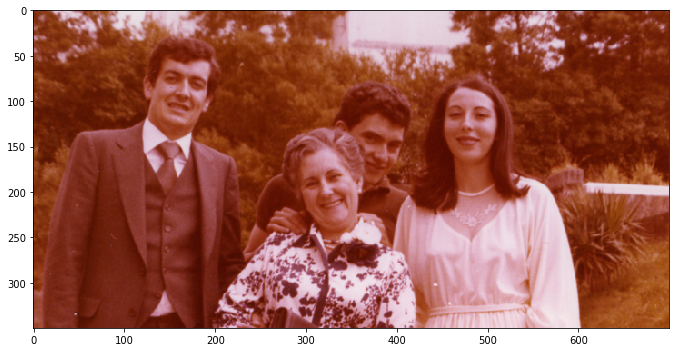

In [48]:
#@markdown ## Elige la imagen con la que trabajar
val = "Boda" #@param ["Boda", "Catedral", "Flores", 'Perro']
import os 
print()
if val == "Boda":
  ruta = 'imgs/bodapedro-2.jpg'
elif val == "Catedral":
  ruta = 'imgs/cathedral.jpg'
elif val == "Flores":
  ruta = 'imgs/flower-orig.png'
elif val == 'Perro':
  ruta = 'imgs/dog.png'
img = io.imread(ruta) 
plt.figure(figsize = (10,5))
plt.rc('axes', labelsize=10) 
io.imshow(img)


# Funciones principales

## Estiramiento del histograma

Implementamos la función histogram_stretching, la cual a partir de un porcentaje que se pasa como parámetro, calcula los percentiles y realiza una transformación pixel a pixel mediante las fórmulas:


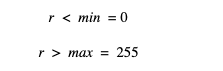

Y posteriormente una saturación en la cual:

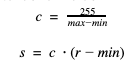


In [40]:
def histogram_stretching(img, percent):
    # Aseguramos que la imagen tiene 3 canales
    assert img.shape[2] == 3
    # Aseguramos que el porcentaje esta en el rango adecuado
    assert percent > 0 and percent < 100
    # Dividimos el porcentaje para mas tarde encontrar los percentiles
    half_percent = percent / 200.0

    # Partimos la imagen en 3 canales
    channels = cv2.split(img)
    i=0
    out_channels = []
    colors = ['red', 'green', 'blue']
    for channel in channels:
        # Redimensionamos el canal a una dimension y ordenamos
        flat = channel.ravel()
        flat = np.sort(flat)

        # Encontramos los percentiles 
        low_val  = int(np.percentile(flat, half_percent*100))
        high_val = int(np.percentile(flat, (1.0 - half_percent)*100))

        # Definimos una figura para plotear los histogramas
        f,(ax1,ax2)=plt.subplots(ncols=2,figsize=(10,3))

        # Histograma del canal original
        ax1.set_title('Histograma original')
        ax1.hist(channel.ravel(), bins = 256, color = colors[i], alpha = 0.5)
        
        # Calculamos la constante de transformacion
        const = 255.0/(high_val-low_val+1)
        # Aplicamos la transformacion al canal
        channel_out = np.round(const*(channel-low_val)).astype('uint8')

        # Saturamos 
        channel_out[channel<low_val] = 0
        channel_out[channel>high_val] = 255

        # Ploteamos el histograma del canal tras la transformacion
        ax2.set_title('Histograma corregido')
        ax2.hist(channel_out.ravel(), bins = 256, color = colors[i], alpha = 0.5)
        plt.show()
        i+=1
        out_channels.append(channel_out)
        
    return cv2.merge(out_channels)


# Ejecución del código

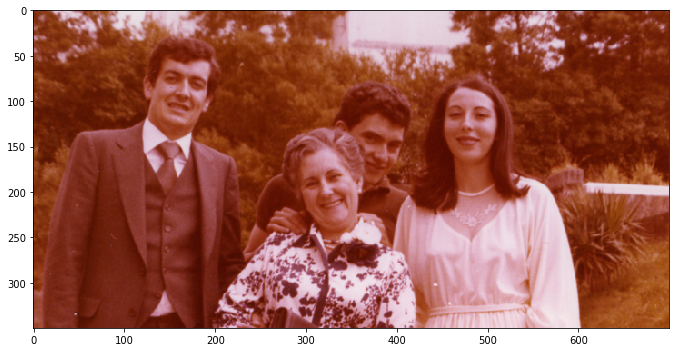

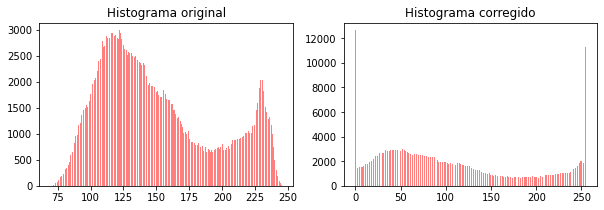

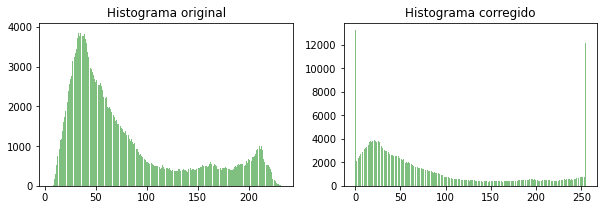

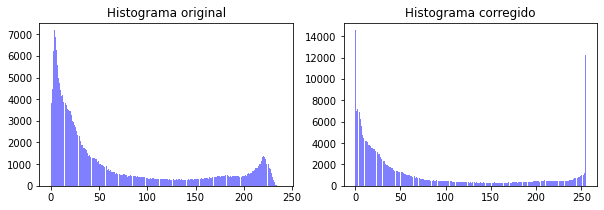

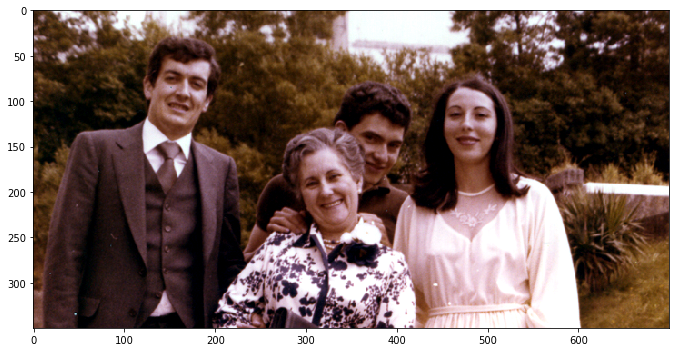

In [47]:
img = io.imread('imgs/bodapedro-2.jpg') 
plt.figure(figsize = (10,5))
plt.rc('axes', labelsize=10) 
io.imshow(img)

out = histogram_stretching(img, 10)
plt.figure(figsize=(10,5))
io.imshow(out)


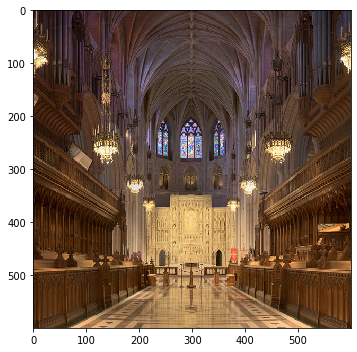

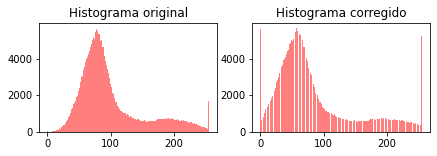

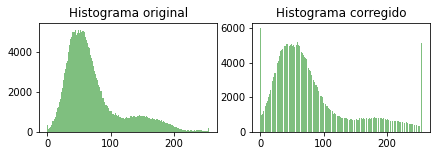

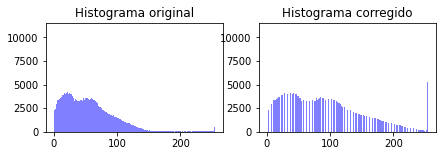

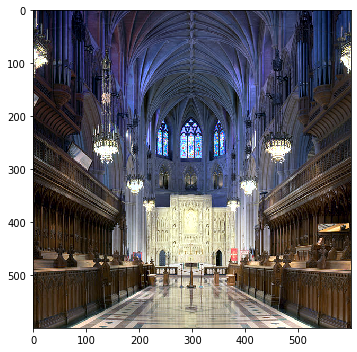

In [35]:
img = io.imread('imgs/cathedral.jpg') 
plt.figure(figsize = (10,5))
plt.rc('axes', labelsize=10) 
io.imshow(img)

out = histogram_stretching(img, 3)
plt.figure(figsize=(10,5))
io.imshow(out)

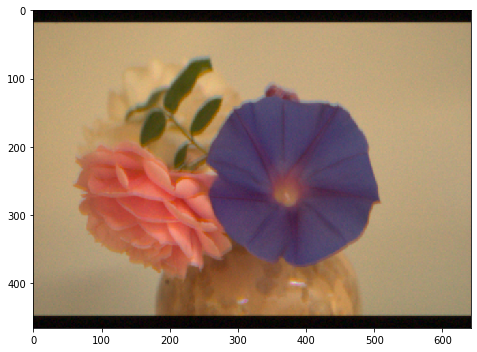

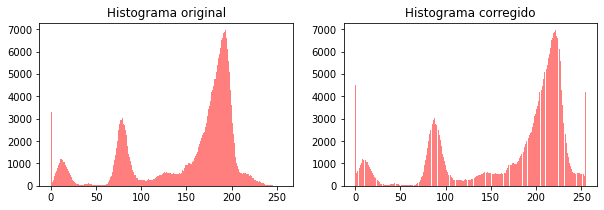

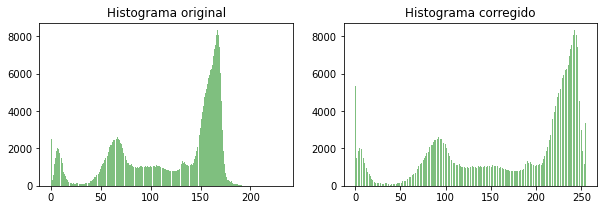

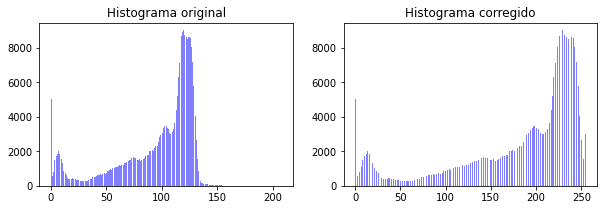

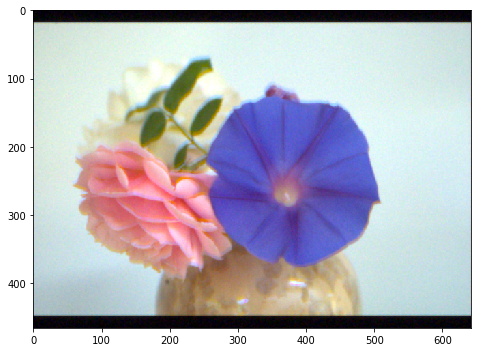

In [44]:
img = io.imread('imgs/flower-orig.png') 
plt.figure(figsize = (10,5))
plt.rc('axes', labelsize=10) 
io.imshow(img)

out = histogram_stretching(img, 3)
plt.figure(figsize=(10,5))
io.imshow(out)

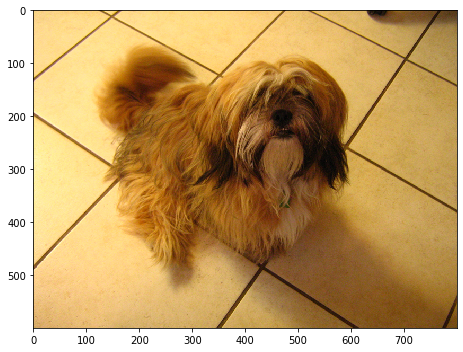

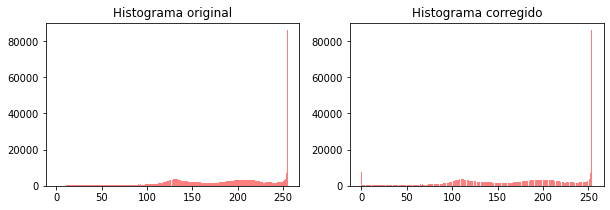

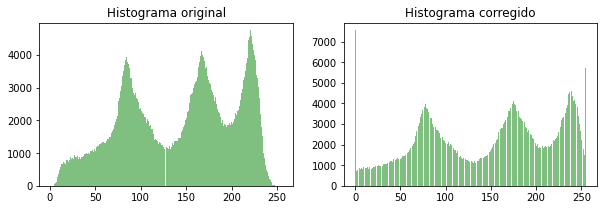

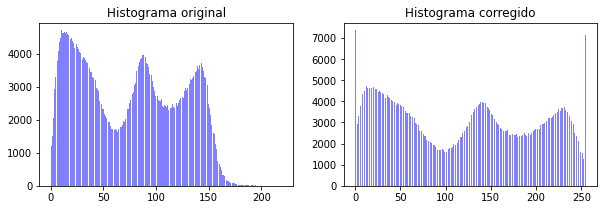

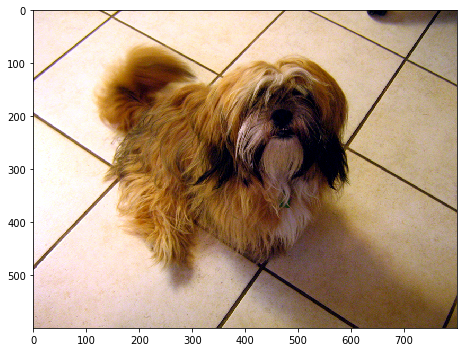

In [45]:
img = io.imread('imgs/dog.png') 
plt.figure(figsize = (10,5))
plt.rc('axes', labelsize=10) 
io.imshow(img)

out = histogram_stretching(img, 3)
plt.figure(figsize=(10,5))
io.imshow(out)

# ANEXO: Funciones implementadas anteriormente

In [ ]:
def filtro_mediana(img, ventana):
    k =  ventana // 2
    for y in range(k, img.shape[0]-k):
        for x in range(k, img.shape[1]-k):
            region = img[y-k:y+k+1, x-k:x+k+1]
            mediana = np.median(region)
            img[y,x] = mediana
    return img

def histograma(img):
    vector = img.flatten()
    bins = 256
    histograma = np.zeros(bins)
    for i in vector:
        histograma[i] += 1
    return histograma

def histograma_acumulado(h):
    h = h.flatten()
    H = np.zeros(len(h))
    H[0] = h[0]
    for i in range(len(h)):
        H[i] = H[i-1]+h[i]
    return H


def equalizador_histograma(img):
    # Partimos en 3 canales
    b,g,r = cv2.split(img)

    # Hacemos el histograma para cada canal
    h_b = histograma(b)
    h_g = histograma(g)
    h_r = histograma(r)

    # Hacemos el histograma acumulado 
    cdf_b = histograma_acumulado(h_b)
    cdf_g = histograma_acumulado(h_g)
    cdf_r = histograma_acumulado(h_r)

    # Normalizamos
    # bottom = min(imRGB(ch,:)); top = max(imRGB(ch,:));
    #imRGB(ch,:) = (imRGB(ch,:)-bottom)255/(top-bottom);
    cdf_n_b = np.ma.masked_equal(cdf_b,0) 
    cdf_n_b = (cdf_b - cdf_b.min())255/(cdf_b.max()-cdf_b.min())
    cdf_final_b = np.ma.filled(cdf_n_b,0).astype('uint8')

    cdf_n_g = np.ma.masked_equal(cdf_g,0) 
    cdf_n_g = (cdf_g - cdf_g.min())255/(cdf_g.max()-cdf_g.min())
    cdf_final_g = np.ma.filled(cdf_n_g,0).astype('uint8')

    cdf_n_r = np.ma.masked_equal(cdf_r,0)
    cdf_n_r = (cdf_r - cdf_r.min())255/(cdf_r.max()-cdf_r.min())
    cdf_final_r = np.ma.filled(cdf_n_r,0).astype('uint8')

    # Mergeamos en los 3 canales
    img_b = cdf_final_b[b]
    img_g = cdf_final_g[g]
    img_r = cdf_final_r[r]

    img_out = cv2.merge((img_b, img_g, img_r))

    return img_out
[18:48]
def transformacion_logaritmica(img, alpha):
    img = img_as_float(img)
    max_r = np.max(img)
    max_s = 1
    c = max_s/np.log(1+(np.exp(alpha)-1)max_r)
    img =cnp.log(1+(np.exp(alpha)-1)*img)
    return img